<a href="https://colab.research.google.com/github/stephenbeckr/numerical-analysis-class/blob/master/Demos/Ch6_conditioning_LeastSquares.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Conditioning and least-squares
Examples of ill-conditioned matrices (the Vandermonde matrix) and applications to least-squares.  Discuss solving least-squares via
1. the [**normal equations**](https://en.wikipedia.org/wiki/Numerical_methods_for_linear_least_squares)
2. the [QR decomposition](https://en.wikipedia.org/wiki/QR_decomposition)

In [163]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.linalg
import scipy.interpolate

from numpy.linalg import cond
from numpy.linalg import norm
from scipy.linalg import solve

mpl.rcParams["figure.figsize"] = [8,6] 
mpl.rcParams["lines.linewidth"] = 2
mpl.rcParams["lines.markersize"] = 10
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams.update({'font.size': 20})

# Helper routine to print out matrices nicely
def matprint(mat, fmt="g",roundToDecimal=2):
  # from https://gist.github.com/braingineer/d801735dac07ff3ac4d746e1f218ab75
  # Modified to round
  if roundToDecimal is not None:
    mat = np.round(mat,decimals=roundToDecimal)
  #col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
  if np.min( mat.flat ) < 0:
    col_maxes = [8 for col in mat.T] # quick hack to deal with fmt='.1e'
  else:
    col_maxes = [7 for col in mat.T] # quick hack to deal with fmt='.1e'
  for x in mat:
    for i, y in enumerate(x):
      if abs(y) >= 1000:
        fmt = '.1e'
      else:
        fmt = 'g'
      print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
    print("")

## Fitting data with a polynomial

We're going to use the Vandermonde matrix (note there are different conventions about ordering the columns; we're going to choose the convention that fits the usual order of polynomial coefficients that `numpy` uses). The Vandermonde matrix for $n+1$ points $\{x_0,x_1,\ldots,x_n\}$ is defined as:

$$
A = \begin{bmatrix} x_0^n & x_0^{n-1} & \dots & x_0 & 1 \\
x_1^n & x_1^{n-1} & \dots & x_1 & 1 \\
\vdots & \vdots & \ddots & \vdots & 1 \\
x_n^n & x_n^{n-1} & \dots & x_n & 1 \\
\end{bmatrix}
$$
so if we want a polynomial $p$ such that $p(x_i) = y_i$ for some data $\{y_0,y_1,\ldots,y_n\}$, then we can put these data into a vector $\mathbf{y}$ and solve 
$$
A\mathbf{c} = \mathbf{y}
$$
i.e.,
$$
\begin{bmatrix} x_0^n & x_0^{n-1} & \dots & x_0 & 1 \\
x_1^n & x_1^{n-1} & \dots & x_1 & 1 \\
\vdots & \vdots & \ddots & \vdots & 1 \\
x_n^n & x_n^{n-1} & \dots & x_n & 1 \\
\end{bmatrix} \cdot
\begin{bmatrix}c_0 \\ c_1 \\ \vdots \\ c_n \end{bmatrix}
= 
\begin{bmatrix}y_0 \\ y_1 \\ \vdots \\ y_n \end{bmatrix}
$$
We do this in order to find the coefficients $\mathbf{c}$ such that we define $p$ as
$$
p(x) = c_0 x^n + c_1 x^{n-1} + \ldots + c_{n-1}x + c_{n}
$$

Note: from now on, we'll often refer to $\mathbf{c}$ as $\mathbf{x}$ so that we're solving the equation $A\mathbf{x}=\mathbf{y}$, in accordance with our usual notation.

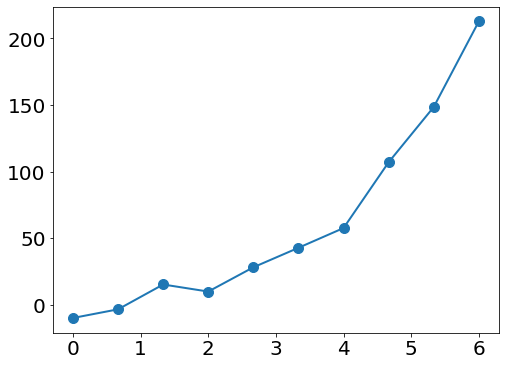

      0        0        0        0        0        0        0        0        0        1  
   0.03     0.04     0.06     0.09     0.13      0.2      0.3     0.44     0.67        1  
  13.32     9.99     7.49     5.62     4.21     3.16     2.37     1.78     1.33        1  
    512      256      128       64       32       16        8        4        2        1  
6.8e+03  2.6e+03   958.92   359.59   134.85    50.57    18.96     7.11     2.67        1  
5.1e+04  1.5e+04  4.6e+03  1.4e+03   411.52   123.46    37.04    11.11     3.33        1  
2.6e+05  6.6e+04  1.6e+04  4.1e+03  1.0e+03      256       64       16        4        1  
1.0e+06  2.2e+05  4.8e+04  1.0e+04  2.2e+03   474.27   101.63    21.78     4.67        1  
3.5e+06  6.5e+05  1.2e+05  2.3e+04  4.3e+03   809.09    151.7    28.44     5.33        1  
1.0e+07  1.7e+06  2.8e+05  4.7e+04  7.8e+03  1.3e+03      216       36        6        1  

The condition number of the square vandermonde matrix is 7.6e+09


In [67]:
domain = (0,6)
x   = np.linspace(domain[0],domain[1],10)

from numpy.random import default_rng
rng = default_rng(123)

#y   = np.cos(x)
y   = x**3 + 10*rng.standard_normal( x.shape )

plt.plot(x,y,'o-')
plt.show()

A = np.vander(x)
matprint(A)
kappa = np.linalg.cond(A)
print(f'\nThe condition number of the square vandermonde matrix is {kappa:.1e}')

[-1.33734109e-04  2.36982283e-01 -5.64831061e+00  5.53350745e+01
 -2.85451406e+02  8.28323601e+02 -1.33177988e+03  1.07424054e+03
 -3.10342394e+02 -9.89121350e+00]


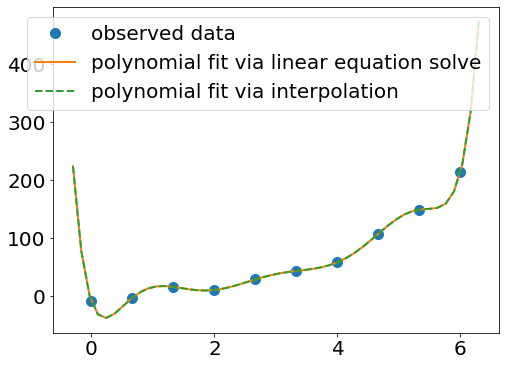

In [78]:
poly_coeff = scipy.linalg.solve(A,y)
print( poly_coeff )
p  = lambda x : np.polyval( poly_coeff, x)

# another way: interpolate
p_v2 = scipy.interpolate.BarycentricInterpolator(x,y)

xGrid =np.linspace(domain[0]-.3,domain[1]+.3,num=50)

plt.plot(x,y,'o',label='observed data')
plt.plot( xGrid, p(xGrid), '-', label='polynomial fit via linear equation solve')
plt.plot( xGrid, p_v2(xGrid), '--', label='polynomial fit via interpolation')
plt.legend()
plt.show()

## Try a lower degree polynomial to reduce overfitting
Another way to reduce overfitting is to do **piecewise** polynomial interpolation, e.g., **splines**, as we talked about earlier.

But for this demo, let's stick with finding a (global, not piecewise) polynomial, but just of lesser degree.

This won't be able to interpolate the data any more

To help us find it, we can just use the first part of the Vandermonde matrix:

In [84]:
deg = 5 # fit a polynomial limited to this degree
AA = A[:,-deg-1:]
print("The partial Vandermonde matrix:")
matprint(AA)
kappa = np.linalg.cond(AA)
print(f'\nThe condition number of the partial (rectangular) vandermonde matrix is {kappa:.1e}')

The partial Vandermonde matrix:
      0        0        0        0        0        1  
   0.13      0.2      0.3     0.44     0.67        1  
   4.21     3.16     2.37     1.78     1.33        1  
     32       16        8        4        2        1  
 134.85    50.57    18.96     7.11     2.67        1  
 411.52   123.46    37.04    11.11     3.33        1  
1.0e+03      256       64       16        4        1  
2.2e+03   474.27   101.63    21.78     4.67        1  
4.3e+03   809.09    151.7    28.44     5.33        1  
7.8e+03  1.3e+03      216       36        6        1  

The condition number of the partial (rectangular) vandermonde matrix is 6.3e+04


... but now we can't solve the system of equations since its rectangular!

In [85]:
poly_coeff = scipy.linalg.solve(AA,y)

ValueError: ignored

... so let's solve in a **least-squares** sense. Instead of $Ax=b$, we're going to solve the **overdetermined** system of equations as
$$\min_x\, \frac12\|A\mathbf{x}-\mathbf{b}\|_2^2 := \frac12\sum_{i=1}^m (\mathbf{a}_i^T \mathbf{x} - b_i )^2
$$
where $A$ is a $m\times n$ matrix, with $m>n$, and the rows of $A$ are
$$A = \begin{bmatrix}-&\mathbf{a}_1^T&- \\ -&\mathbf{a}_2^T&- \\ \vdots \\ -&\mathbf{a}_m^T&- \end{bmatrix}.
$$


[ -0.08426957   1.16053569  -3.82880371   3.14557491  14.61902257
 -10.49787878]


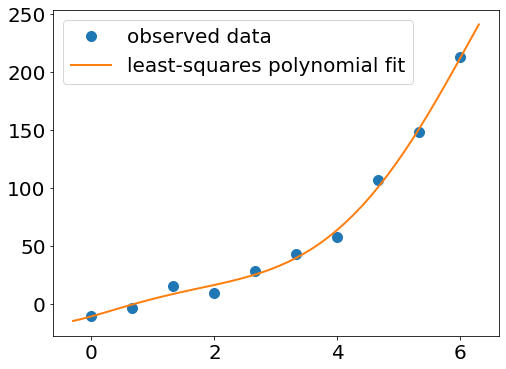

In [95]:
poly_coeff, residual, rnk, s = scipy.linalg.lstsq(AA,y)  # use `lstsq`
print( poly_coeff )
p  = lambda x : np.polyval( poly_coeff, x)

xGrid =np.linspace(domain[0]-.3,domain[1]+.3,num=50)

plt.plot(x,y,'o',label='observed data')
plt.plot( xGrid, p(xGrid), '-', label='least-squares polynomial fit')
plt.legend()
plt.show()

## How do we solve a least-squares problem?
Well, we can call `scipy.linalg.lstsq`, but what does `lstsq` do "under-the-hood"?

(for Matlab users, both square and overdetermined (and even underdetermined) equations can all be solved with backslash `\`, aka [`mldivide`](https://www.mathworks.com/help/matlab/ref/mldivide.html).  See more at the [Matlab systems-of-equations](https://www.mathworks.com/help/matlab/math/systems-of-linear-equations.html) documentation which also shows you how to use the new [`decomposition`](https://www.mathworks.com/help/matlab/ref/decomposition.html) function )


### Let's start with what not to do
This method isn't always bad, but it **squares the condition number** so its in appropriate if your original system is already ill-conditioned and/or if you need high-accuracy in your answer.

This is also the method that's usually taught in introductory statistics classes, since it's the most straightforward.

Recall we want to solve
$$\min_x\, \frac12\|A\mathbf{x}-\mathbf{b}\|_2^2 := \frac12\sum_{i=1}^m (\mathbf{a}_i^T \mathbf{x} - b_i )^2
$$
and define
$$F(\mathbf{x}) := \frac12\sum_{i=1}^m (\mathbf{a}_i^T \mathbf{x} - b_i )^2,\quad
f_i(\mathbf{x}) := \frac12 (\mathbf{a}_i^T \mathbf{x} - b_i )^2
$$
so
$$
F(\mathbf{x}) = \sum_{i=1}^m f_i(\mathbf{x})
$$

Now to solve $\min_x\, F(\mathbf{x})$ we do [Fermat's theorem](https://en.wikipedia.org/wiki/Fermat%27s_theorem_(stationary_points)):  we set the derivative equal to zero (or in this case, the *gradient*), and solve for $\nabla F(\mathbf{x})=0$.  So what is $\nabla F$? Well, by the "sum rule", $\nabla F(\mathbf(x)) = \sum_{i=1}^m \nabla f_i(\mathbf{x})$.  So what is $\nabla f_i(\mathbf{x})$?  The gradient is $n$ components, one for each variable $x_j$.  So 
\begin{align*}
\big( \nabla f_i(\mathbf{x}) \big)_j &= \frac{\partial}{\partial x_j}\frac12 (\mathbf{a}_i^T \mathbf{x} - b_i )^2 \\
&= \frac{\partial}{\partial x_j}\frac12 \left( \sum_{j'=1}^n a_{ij'}x_{j'} - b_i \right)^2 \\
&= \left( \sum_{j'=1}^n a_{ij'}x_{j'} - b_i \right)
\frac{\partial}{\partial x_j} \left( \sum_{j'=1}^n a_{ij'}x_{j'} - b_i \right)\quad\text{via the chain rule} \\
&= \left( \sum_{j'=1}^n a_{ij'}x_{j'} - b_i \right)
 \left( \sum_{j'=1}^n \frac{\partial}{\partial x_j} a_{ij'}x_{j'} - b_i \right) \\
 &= \left( \sum_{j'=1}^n a_{ij'}x_{j'} - b_i \right)
 \left(  a_{ij} \right) \\
\end{align*}
and so
$$
\nabla f_i(\mathbf{x}) = \left( \sum_{j'=1}^n a_{ij'}x_{j'} - b_i \right) \mathbf{a}_i
= \mathbf{a}_i(\mathbf{a}_i^T\mathbf{x} - b_i) 
$$
so
$$
\nabla F(\mathbf{x}) = \sum_{i=1}^m \mathbf{a}_i(\mathbf{a}_i^T\mathbf{x} - b_i) = A^T(A\mathbf{x}-\mathbf{b}).
$$

So to find the $\mathbf{x}$ to solve the least-squares problem, we solve 
$$A^T(A\mathbf{x}-\mathbf{b})=0,\quad\text{i.e.,}\quad
A^TA\mathbf{x}=A^T\mathbf{b}$$
which is known as the **normal equations**.  So we can just solve a system of equations, but the catch is that $\kappa(A^TA) = \kappa(A)^2$ so we've just doubled the number of digits we're going to lose.


In [159]:
# Let's make a problem that has a known solution
# e.g., we'll re-generate the data without noise, and make a degree 3 fit
deg = 7
x   = np.linspace(domain[0],domain[1],deg+1)
# tmp   = [1]
# tmp.extend(deg*[0])
# cTrue = np.array( tmp )
#y   = x**deg

cTrue = np.ones(deg+1)
y   = np.polyval(cTrue,x)

A = np.vander(x)
A = A[:,-deg-1:]


# Get reference solution
# call this "c" for "coefficients". Should be [1,0,0,0] since a true cubic
c1,_,_,_ = scipy.linalg.lstsq(A,y) 


print(f"Condition number of AA is {cond(A):.1e}")
G = A.T @ A  # often called the Gram Matrix
print(f"Condition number of AA^T AA is {cond(G):.1e}") # should be cond(AA)^2

# Get solution via solving the normal equations
c2 = solve( G, A.T @ y )

eps = np.finfo(float).eps  # machine epsilon


e1=norm(cTrue-c1)/norm(cTrue)
e2=norm(cTrue-c2)/norm(cTrue)
expected1 = eps*cond(A) # expected error
expected2 = eps*cond(G) # expected error
print(f'Error via lstsq:\t {e1:.1e}, and expected an error roughly {expected1:.1e}')
print(f'Error via normal eq:\t {e2:.1e}, and expected an error roughly {expected2:.1e}')

Condition number of AA is 2.6e+07
Condition number of AA^T AA is 6.9e+14
Error via lstsq:	 1.6e-10, and expected an error roughly 5.8e-09
Error via normal eq:	 1.3e-04, and expected an error roughly 1.5e-01


### So then how do we solve a least-squares problem stably?
Two reasonable techniques are
1. QR factorization
2. SVD factorization

Let's go over the QR method.  The QR factorization:  
![link](https://github.com/cu-numcomp/numcomp-class/raw/master/img/TB-FullQR.png)
and the reduced aka thin aka economic QR:
![link](https://github.com/cu-numcomp/numcomp-class/raw/master/img/TB-ReducedQR.png)
where
$$ Q^TQ = I$$
meaning $Q$ is an orthogonal matrix (or for the reduced QR, its partial orthogonal).  Since we're working with real numbers, recall "[unitary](https://en.wikipedia.org/wiki/Unitary_matrix)" = "[orthogonal](https://en.wikipedia.org/wiki/Orthogonal_matrix)".

Now a neat property of the Euclidean norm $\| \cdot \|_2$ is that it is unitarily invariant, meaning for any $\mathbf{z}$ that $\| Q \mathbf{z} \|_2 = \|\mathbf{z}\|_2$.  
In fact, we'll see everything better if we use the fact that 
$$
\|\mathbf{z}\|_2^2 = \mathbf{z}^T\mathbf{z}
$$
Hence, since $A=QR$,
\begin{align*}
\arg \min_x\; \|A\mathbf{x} - \mathbf{b} \|_2^2 &= \arg \min_x\; ( A\mathbf{x} - \mathbf{b} )^T (A\mathbf{x} - \mathbf{b} ) \\
&= \arg \min_x \;( A\mathbf{x})^T(A\mathbf{x}) - 2\mathbf{b}^TA\mathbf{x} + \mathbf{b}^T\mathbf{b} \\
&= \arg\min_x \;( QR\mathbf{x})^T(QR\mathbf{x}) - 2\mathbf{b}^TQR\mathbf{x} + \mathbf{b}^T\mathbf{b} \\
&= \arg\min_x \; \mathbf{x}^TR^TQ^T(QR\mathbf{x}) - 2\mathbf{b}^TQR\mathbf{x} + \mathbf{b}^T\mathbf{b} \\ 
&= \arg\min_x \; \mathbf{x}^TR^TQ^T(QR\mathbf{x}) - 2\mathbf{b}^TQR\mathbf{x} + \mathbf{b}^TQQ^T\mathbf{b} \quad\text{since constants don't affect the minimizer}\\ 
&= \arg\min_x \; \mathbf{x}^TR^TR\mathbf{x} - 2\mathbf{b}^TQR\mathbf{x} + \mathbf{b}^TQQ^T\mathbf{b} \\ 
&= \arg\min_x \; \mathbf{x}^TR^TR\mathbf{x} - 2\widetilde{\mathbf{b}}R\mathbf{x} + \widetilde{\mathbf{b}}^T\widetilde{\mathbf{b}}, \quad \widetilde{\mathbf{b}} := Q^T\mathbf{b}\\ 
&= \arg\min_x\; \|R\mathbf{x} - \widetilde{\mathbf{b}}\|_2^2 \quad\text{completing the square}
\end{align*}
and the cool thing is that this is now a square $n\times n$ system, so in fact we can just solve $R\mathbf{x}=\widetilde{\mathbf{b}}$ (note that $\widetilde{\mathbf{b}}$ is a different size than $\mathbf{b}$: it's the project of $\mathbf{b}$ onto the column space of $A$). And even nicer, $R$ is upper triangular, so this is just back-substitution.

In [165]:
Q,R = scipy.linalg.qr(A,mode='economic')
print('Q is')
matprint(Q)
print(' and Q^TQ is ')
matprint(Q.T @ Q)
print('R is')
matprint(R)

Q is
       0         0        -0         0         0        -0         0        -1  
      -0        -0        -0     -0.06      0.39      0.85      0.35         0  
      -0     -0.01     -0.08     -0.42      0.72     -0.13     -0.53        -0  
      -0     -0.05     -0.34     -0.68     -0.04     -0.27      0.59         0  
   -0.02     -0.22     -0.65     -0.16     -0.42      0.36     -0.44        -0  
   -0.09     -0.54     -0.45      0.52      0.36     -0.22      0.21         0  
   -0.32     -0.75      0.49     -0.26     -0.13      0.07     -0.06        -0  
   -0.94      0.31     -0.11      0.04      0.02     -0.01      0.01         0  
 and Q^TQ is 
      1       -0        0       -0       -0       -0       -0       -0  
     -0        1       -0        0        0       -0        0        0  
      0       -0        1       -0        0       -0       -0        0  
     -0        0       -0        1        0        0       -0       -0  
     -0        0        0        0       

In [169]:
c3 = scipy.linalg.solve_triangular(R,Q.T@y, lower=False)


e3=norm(cTrue-c3)/norm(cTrue)
expected3 = eps*cond(A) # expected error
print(f'Error via lstsq:\t {e1:.1e}, and expected an error roughly {expected1:.1e}')
print(f'Error via normal eq:\t {e2:.1e}, and expected an error roughly {expected2:.1e}')
print(f'Error via QR:    \t {e3:.1e}, and expected an error roughly {expected3:.1e}')

Error via lstsq:	 1.6e-10, and expected an error roughly 5.8e-09
Error via normal eq:	 1.3e-04, and expected an error roughly 1.5e-01
Error via QR:    	 1.5e-11, and expected an error roughly 5.8e-09


we actually did a bit better than `scipy`'s builtin least square solver!